In [262]:
using JLD2, FileIO, DataFrames, CSV, PyPlot
using SpecialFunctions: erfc, erfcinv

using PyCall
LogNorm = pyimport("matplotlib.colors").LogNorm

include("get_lamost_spectra.jl")
;

### load battery

In [3]:
using FITSIO
lamost = CSV.read("../cats/LAMOST-dr4v2-stellar.csv");
tenth = Set(CSV.read("one_tenth_of_LAMOST.csv").obsid);
battery = DataFrame()
FITS("the-battery-stars.rc.fits") do hdus
    battery.fn = read(hdus[2], "lamost_id")
    battery.ra = read(hdus[2], "ra")
    battery.dec = read(hdus[2], "dec")
end
;
battery = join(battery, lamost, on=[:ra, :dec]);
battery = Set(battery.obsid) ∩ tenth;
length(battery)

259

### load test results (TODO: fix errors on k8t1000)

In [235]:
iis = 1:20
dfs = map(iis) do i
    df = load("k4_t1000_test/$i.jld2")["out"]
end
k4df = vcat(dfs...);

iis = [i for i in 1:20 if i != 3]
dfs = map(iis) do i
    df = load("k8_t1000_test/$i.jld2")["out"]
end
k8df = vcat(dfs...);

iis = 1:20
dfs = map(iis) do i
    df = load("k16_t1000_test/$i.jld2")["out"]
end
k16df = vcat(dfs...)

dfs = Dict(4=>k4df, 8=>k8df, 16=>k16df);

for k in [4, 8, 16]
    dfs[k] = join(dfs[k], lamost[:, [:obsid, :lmjd, :teff, :feh, :logg, :snrz]], on=:obsid, kind=:left)
end

### define masked region

In [236]:
include("air_vacuum.jl")

wl_grid = load("wl_grid.jld2")["wl_grid"]
Δλ = 7                                                                                    
li_air = 6707.85
li_vac = air_to_vac(li_air)
line_mask = li_air - Δλ .< wl_grid .< li_air + Δλ
;

### model comparison

In [237]:
ϕ(x, μ, σ) = exp(-1/2 * (x-μ)^2/σ^2) #gaussian kernel
n = sum(line_mask)
M = zeros(2 + n, n)
M[1, :] = ϕ.(wl_grid[line_mask], li_vac, li_air/3600.)
M[1, :] ./= sqrt(sum(M[1, :].^2))
M[2, :] .= sqrt(1/n)
for i in 3:(2+n)
    M[i, i-2] = 1.
end

for (k, df) in dfs
    D = reduce(hcat, df.diff) 
    E = reduce(hcat, df.err).^2
    l1 = M.^2 * (1 ./ E)
    l2 = M * (D./E)
    loss = @. -l2^2 / l1
    df[!, :loss] = collect(eachcol(loss))
    df[!, :isline] = argmin.(df.loss) .== 1
    df.amplitude = first.(collect(eachcol(l2 ./ l1)))
    
    df.delta_chi2 = map(eachrow(df)) do row
        row.isline ? minimum(row.loss[2:end]) - row.loss[1] : NaN
    end
    
    df.inbat = map(eachrow(df)) do row
        row.obsid in battery
    end
end

In [238]:
for (k, df) in dfs
    df.match = df.isline .& (df.delta_chi2 .> 20) .& (df.amplitude .> 0.03)
    
    println("k = $k")
    println("fraction of all spectra that match a line model: ", sum(df.match) / size(df, 1))
    println("fraction of battery stars that match a line model: ", sum(df.match .& df.inbat) / sum(df.inbat))
    println("$(sum(df.match .& df.inbat)) match &  battery")
    println("$(sum(df.match .& (.! df.inbat))) match & ¬battery")
    println("$(sum((.! df.match) .& df.inbat)) ¬match & battery")
    println("$(sum((.! df.match) .& (.! df.inbat))) ¬match & ¬battery")
    
    oldmask = (df.lmjd .< 56800) .& (df.logg .< 3.5)
    println("flagged $(sum(df[oldmask, :match])) including $(sum(df[oldmask, :match] .& df[oldmask, :inbat])) of $(sum(df[oldmask, :inbat])) in battery for dr2 giants")
    println()
    
end

println()
intersection = intersect([Set(df.obsid[df.match]) for (k, df) in dfs]...)
println("$(length(intersection)) stars in the intersection of all 3")

k = 4
fraction of all spectra that match a line model: 0.0017829554745989451
fraction of battery stars that match a line model: 0.6838235294117647
186 match &  battery
623 match & ¬battery
86 ¬match & battery
452846 ¬match & ¬battery
flagged 244 including 167 of 247 in battery for dr2 giants

k = 16
fraction of all spectra that match a line model: 0.002247978472300277
fraction of battery stars that match a line model: 0.6875
187 match &  battery
833 match & ¬battery
85 ¬match & battery
452636 ¬match & ¬battery
flagged 306 including 168 of 247 in battery for dr2 giants

k = 8
fraction of all spectra that match a line model: 0.001837361066968563
fraction of battery stars that match a line model: 0.6679841897233202
169 match &  battery
623 match & ¬battery
84 ¬match & battery
430177 ¬match & ¬battery
flagged 242 including 152 of 231 in battery for dr2 giants


628 stars in the intersection of all 3


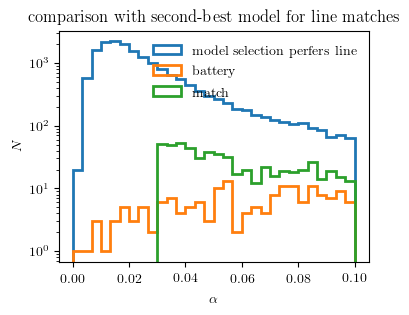

PyObject Text(0.5, 1.0, 'comparison with second-best model for line matches')

In [239]:
figure(figsize=(4,3))
df = dfs[4]
plt.hist(df[df.isline, :amplitude], bins=30, range=(0, 0.1), histtype="step", label="model selection perfers line", lw=2)
plt.hist(df[df.inbat, :amplitude], bins=30, range=(0, 0.1), histtype="step", label="battery", lw=2)
plt.hist(df[df.match, :amplitude], bins=30, range=(0, 0.1), histtype="step", label="match", lw=2)
legend()
plt.yscale("log")
ylabel(L"N")
xlabel(L"\alpha")
title("comparison with second-best model for line matches")

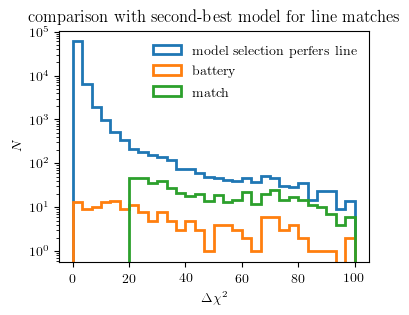

PyObject Text(0.5, 1.0, 'comparison with second-best model for line matches')

In [240]:
figure(figsize=(4,3))
df = dfs[4]
plt.hist(df[df.isline, :delta_chi2], bins=30, range=(0, 100), histtype="step", label="model selection perfers line", lw=2)
plt.hist(df[df.inbat, :delta_chi2], bins=30, range=(0, 100), histtype="step", label="battery", lw=2)
plt.hist(df[df.match, :delta_chi2], bins=30, range=(0, 100), histtype="step", label="match", lw=2)
legend()
plt.yscale("log")
ylabel(L"N")
xlabel(L"\Delta \chi^2")
title("comparison with second-best model for line matches")

# science

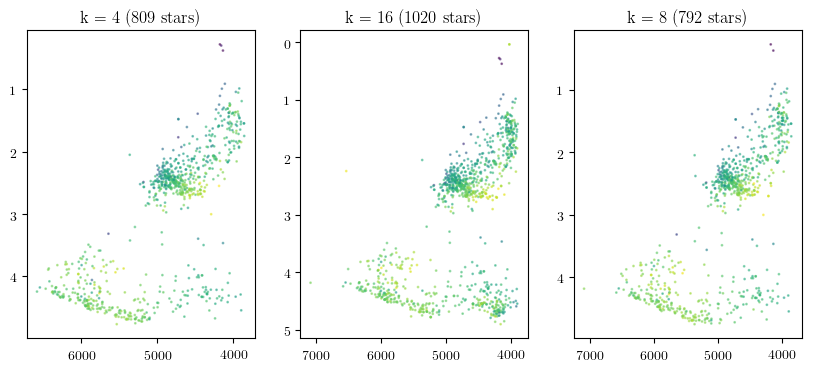

In [264]:
axs = subplots(1, 3, figsize=(10, 4))[2]
for (i, (k, df)) in enumerate(dfs)
    sca(axs[i])
    title("k = $k ($(sum(df.match)) stars)")
    scatter(df[df.match, :teff], df[df.match, :logg], s=1, zorder=-k, label=string(k), c=df[df.match, :feh], alpha=0.5, cmap="viridis")
    gca().invert_yaxis()
    gca().invert_xaxis()
end


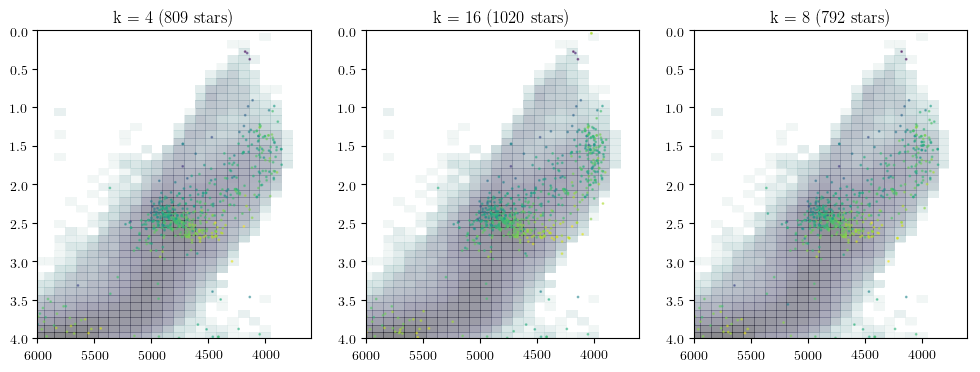

In [266]:
axs = subplots(1, 3, figsize=(12, 4))[2]
for (i, (k, df)) in enumerate(dfs)
    sca(axs[i])
    title("k = $k ($(sum(df.match)) stars)")
    plt.hist2d(df.teff, df.logg, cmap="bone_r", bins=50, zorder=-1, norm=LogNorm())
    scatter(df[df.match, :teff], df[df.match, :logg], s=1, label=string(k), c=df[df.match, :feh], alpha=0.5, cmap="viridis")
    xlim(3600, 6000)
    ylim(0,4)
    gca().invert_yaxis()
    gca().invert_xaxis()
end


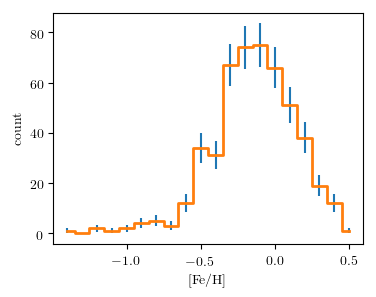

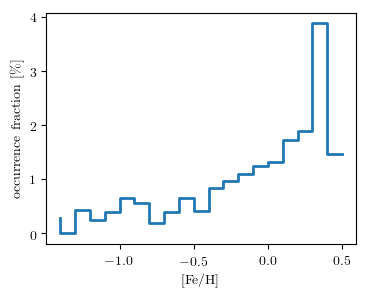

PyObject Text(0.5, 23.999999999999993, '[Fe/H]')

In [251]:
using StatsBase
df = dfs[4]
fehbins=-1.5:0.1:0.5

gmatch = df.match .& (df.logg .< 3)

h = fit(Histogram, df[gmatch, :feh], fehbins)
h2 = fit(Histogram, df[df.logg .< 3, :feh], fehbins)
midpoints = h.edges[1][1:end-1] + diff(h.edges[1])

figure(figsize=(4,3))
plt.errorbar(midpoints, h.weights, sqrt.(h.weights), ls="")
plt.step(midpoints, h.weights, where="mid", lw=2)
ylabel("count")
xlabel("[Fe/H]")

figure(figsize=(4,3))
plt.step(midpoints, h.weights./h2.weights * 100, lw=2)
ylabel("occurrence fraction [\\%]")
xlabel("[Fe/H]")

# look at spectra

In [113]:
function plot_spectrum(row)
    
    print("obsid: ", row.obsid)
    println(" ... in the battery? $(row.obsid in battery)")
    #println("A=$(row.A), σ=$(row.σ)")
    
    download_lamost_spectra([row.obsid], verbose=false)
    wl, flux, ivar = load_lamost_spectrum(row.obsid)
    download_lamost_spectra(row.neighbors, verbose=false)
    F = hcat((n->load_lamost_spectrum(n)[2]).(row.neighbors)...)
    #println(F*row.weights)
    
    println("distance to synthetic spectrum:", sum((F*row.weights .- flux).*sqrt.(ivar)))
    
    figure(figsize=(3,3))
    ylabel("residuals")
    xlabel(L"$\lambda$ [\AA]")
    errorbar(wl_grid[line_mask], row.diff, yerr=row.err, label="data")
    #plt.plot(wl_grid[line_mask], ϕ.(wl_grid[line_mask], li_vac, row.σ)*row.A, label="model")
    #legend()
    
    figure(figsize=(12, 3))
    ylabel(L"F/F_\mathrm{cont}")
    xlabel(L"$\lambda$ [\AA]")
    plt.plot(wl, flux, label="data")
    axvspan(li_air - Δλ, li_air + Δλ, alpha=0.2, color="gray")
    plt.plot(wl, F*row.weights, label="synthetic")
    legend()
    
    figure(figsize=(12, 3))
    ylabel(L"F/F_\mathrm{cont}")
    xlabel(L"$\lambda$ [\AA]")
    errorbar(wl, flux, yerr=ivar.^(-1/2), label="data");
    axvspan(li_air - Δλ, li_air + Δλ, alpha=0.2, color="gray")
    plt.plot(wl, F*row.weights, label="synthetic")
    legend()
    xlim(6660, 6750)
    ylim(0.9, 1.1)
    
    ;
end

plot_spectrum (generic function with 1 method)

[-26.6031, -7.36915, -0.317852, -0.226771, -0.121529, -0.000114052, -4.96569, -11.4381, -12.047, -0.44826, -1.92323]
14.556046432695638
obsid: 234106014 ... in the battery? true
of 1 spectra, 0 need to be downloaded
of 8 spectra, 0 need to be downloaded
distance to synthetic spectrum:

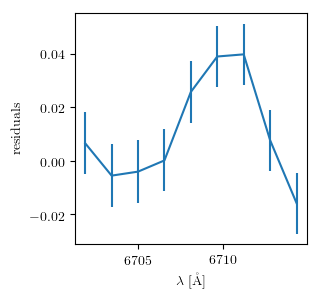

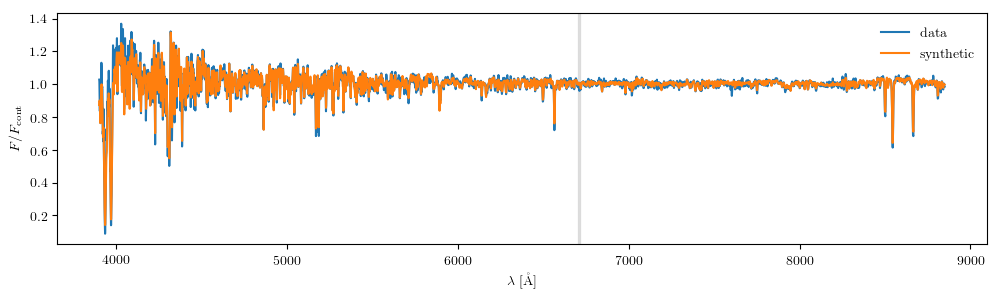

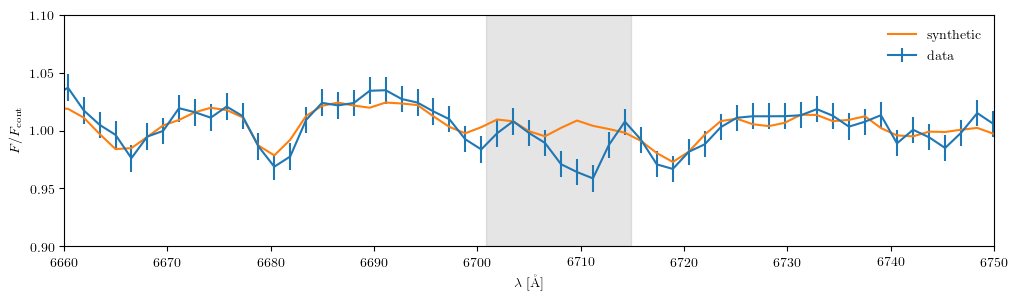

143.17908


(0.9, 1.1)

In [116]:
df = dfs[8]
i = findall((df.match) .& (.! df.inbat) .& (df.lmjd .< 56500))[2]
println(df[i, :loss])
println(df[i, :delta_chi2])
plot_spectrum(df[i, :])

### in terms of LAMOST labels, the things we miss from the battery are the low-SNR objects

In [89]:
df = dfs[8]
df = join(df, lamost, on=:obsid, kind=:left, makeunique=true);

,obsid,diff
,Int64,Array…
1,96505024,"[-0.00948942, 0.0210078, 0.0357233, 0.0061956, 0.0270883, 0.023686, 0.0355071, 0.0177566, 0.00311309]"
2,157702018,"[0.00659251, 0.00911582, -0.000850916, 0.0049051, 0.0115618, 0.00435567, 0.00322807, 0.0166885, 0.00667107]"
3,74516223,"[0.0021168, 0.0119054, -0.00469363, -0.00154597, 0.00949192, 0.00575352, 0.00373995, -0.00264108, -0.000166655]"
4,301615250,"[-0.0102569, -0.017803, 0.0302487, -0.00681013, -0.0243752, -0.0631309, -0.0634295, -0.00508732, 0.00829911]"
5,458215077,"[-0.00120819, -0.00219953, -0.00172424, 0.000757933, 0.00236011, 0.00294256, -0.0028218, -0.00330102, -0.0013783]"
6,170402050,"[-0.000587463, 0.00115216, 0.00496471, 0.00188112, 0.00104868, 0.00259459, 0.000953913, -0.000855803, -0.00177175]"
7,140305228,"[-0.00383329, -0.00381744, -0.00170624, -0.00468743, 0.000544786, -0.00261557, 0.00749767, 0.0149348, -0.00360739]"
8,19104024,"[-0.0359884, 0.00744033, 0.0679818, -0.0438888, -0.104386, -0.141441, -0.102045, -0.0329102, -0.0905855]"
9,302508093,"[-0.0053345, -0.026085, -0.00376469, -0.00838995, -0.0248262, -0.0283386, -0.015839, -0.0224504, -0.00959927]"


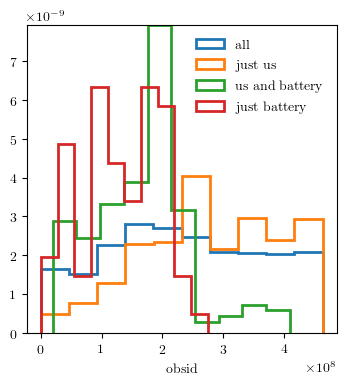

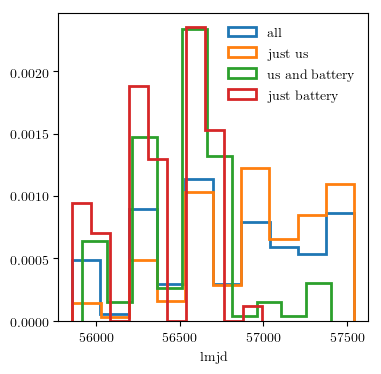

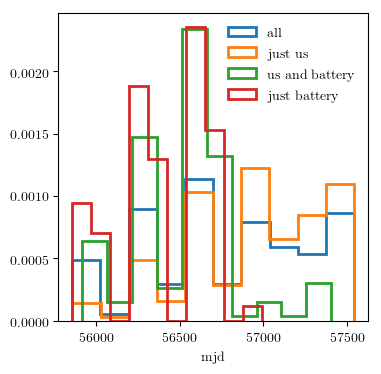

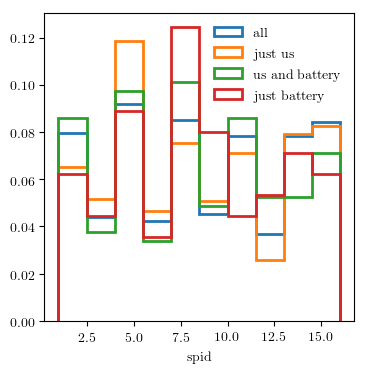

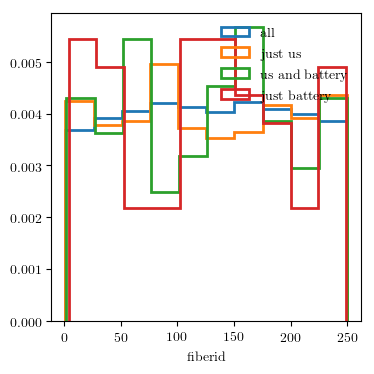

Figure(PyObject <Figure size 400x400 with 1 Axes>)

Figure(PyObject <Figure size 400x400 with 1 Axes>)

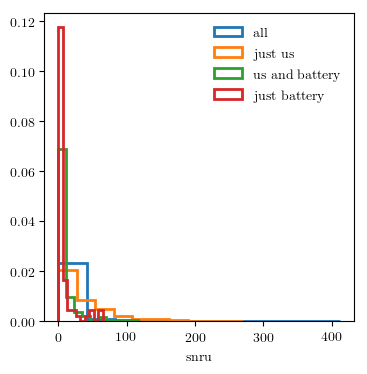

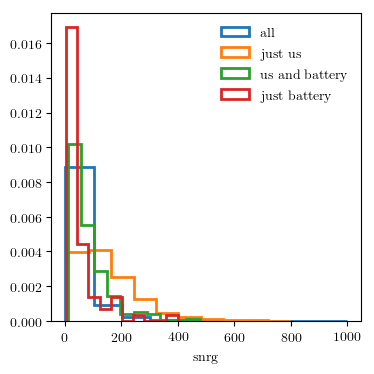

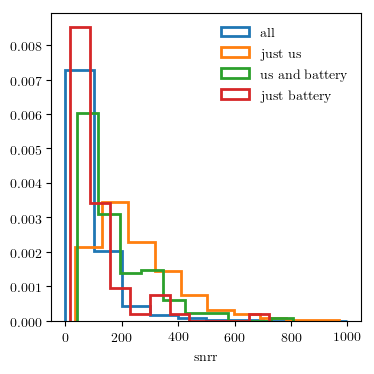

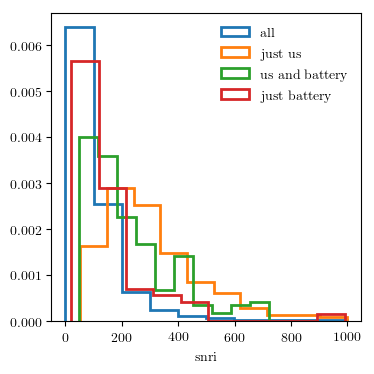

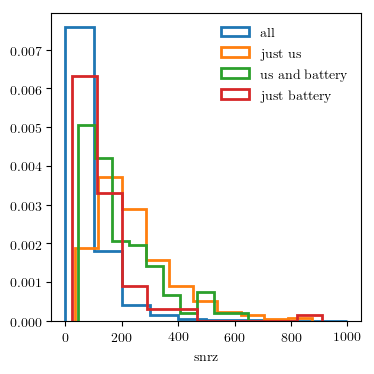

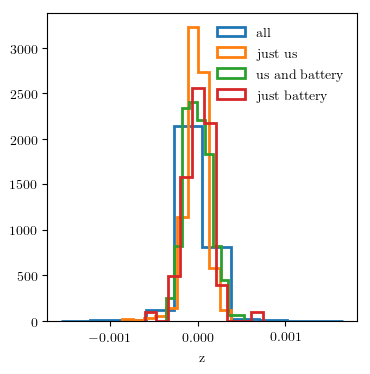

Figure(PyObject <Figure size 400x400 with 1 Axes>)

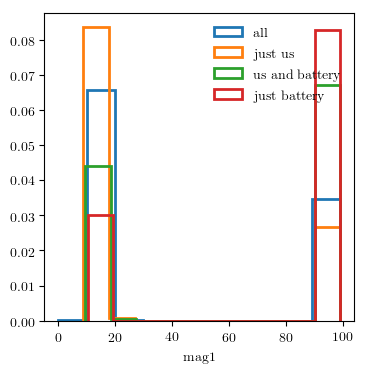

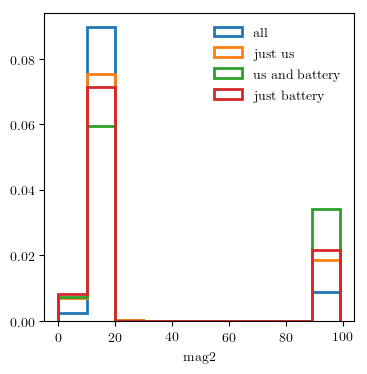

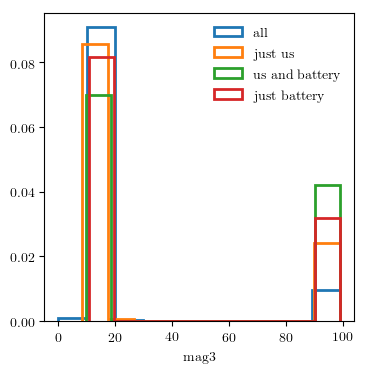

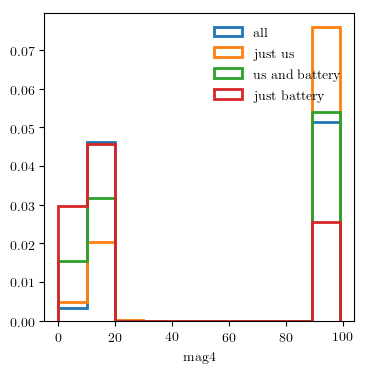

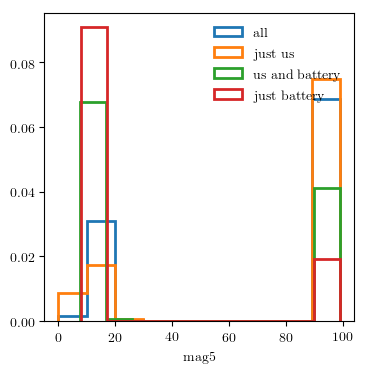

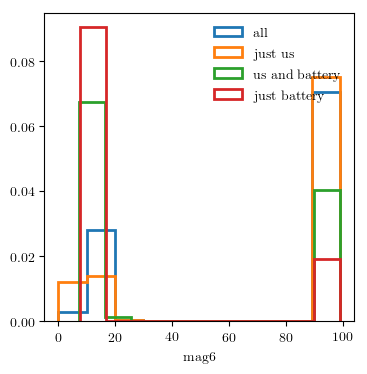

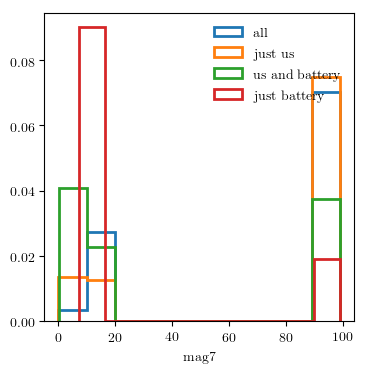

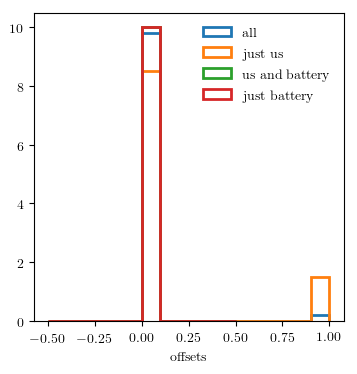

Figure(PyObject <Figure size 400x400 with 1 Axes>)

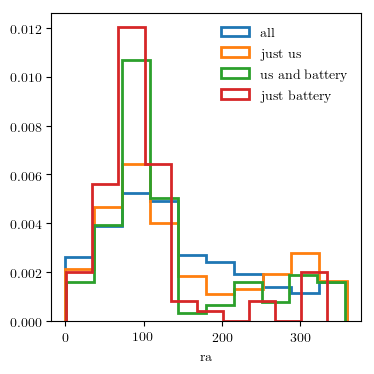

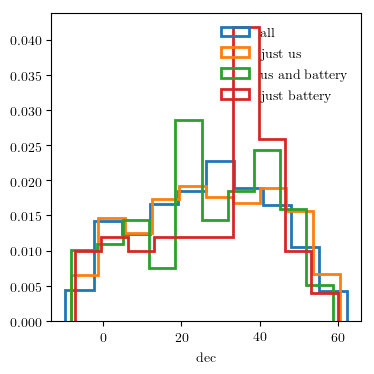

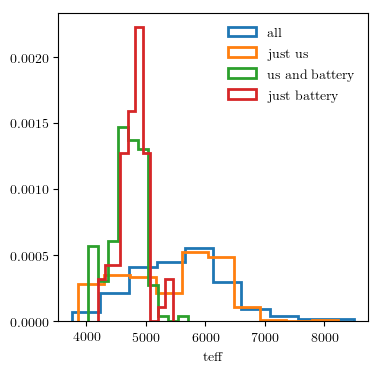

Figure(PyObject <Figure size 400x400 with 1 Axes>)

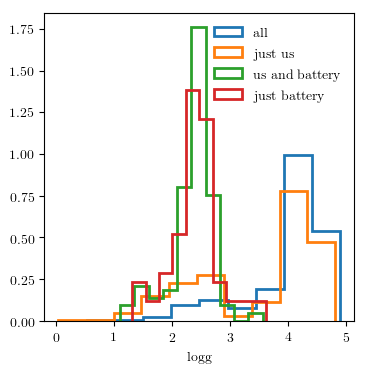

Figure(PyObject <Figure size 400x400 with 1 Axes>)

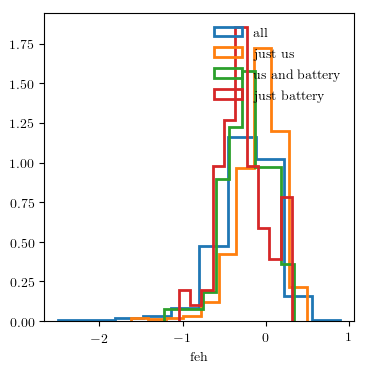

Figure(PyObject <Figure size 400x400 with 1 Axes>)

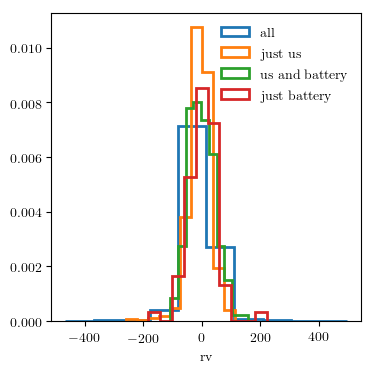

Figure(PyObject <Figure size 400x400 with 1 Axes>)

In [90]:
for a in names(lamost)
    if typeof(lamost[1, a]) <: Number
        figure(figsize=(4,4))
        plt.hist(df[! , a], normed=true, histtype="step", label="all", lw=2)
        plt.hist(df[df.match .& (.! df.inbat), a], normed=true, histtype="step", label="just us", lw=2)
        plt.hist(df[df.match .& (df.inbat), a], normed=true, histtype="step", label="us and battery", lw=2)
        plt.hist(df[(.! df.match) .& (df.inbat), a], normed=true, histtype="step", label="just battery", lw=2)
        legend()
        xlabel(String(a))
    end
end

# old stuff 

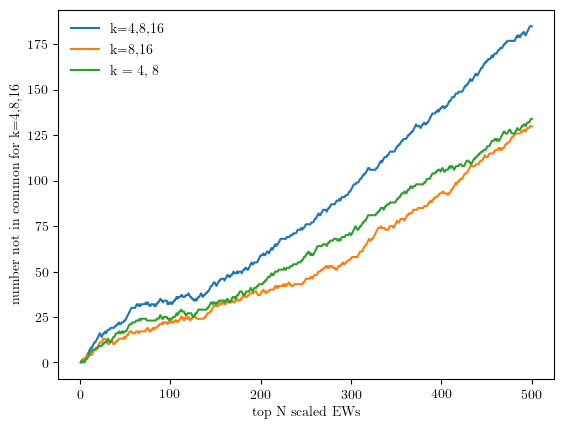

PyObject Text(22.299550986642984, 0.5, 'number not in common for k=4,8,16')

In [36]:
sk4df = sort(k4df, :SEW, rev=true)
sk8df = sort(k8df, :SEW, rev=true)
sk16df = sort(k16df, :SEW, rev=true)
sk4df = sk4df[.! isnan.(sk4df.SEW), :]
sk8df = sk8df[.! isnan.(sk8df.SEW), :]
sk16df = sk16df[.! isnan.(sk16df.SEW), :]


N = 500
incommon(xs) = length(intersect((Set.(xs))...))
c = map(1:N) do i
    i - incommon([df.obsid[1:i] for df in [sk4df, sk8df, sk16df]])
end
plot(1:N, c, label="k=4,8,16")
c = map(1:N) do i
    i - incommon([df.obsid[1:i] for df in [sk8df, sk16df]])
end
plot(1:N, c, label="k=8,16")
c = map(1:N) do i
    i - incommon([df.obsid[1:i] for df in [sk4df, sk8df]])
end
plot(1:N, c, label="k = 4, 8")
legend()
xlabel("top N scaled EWs")
ylabel("number not in common for k=4,8,16")

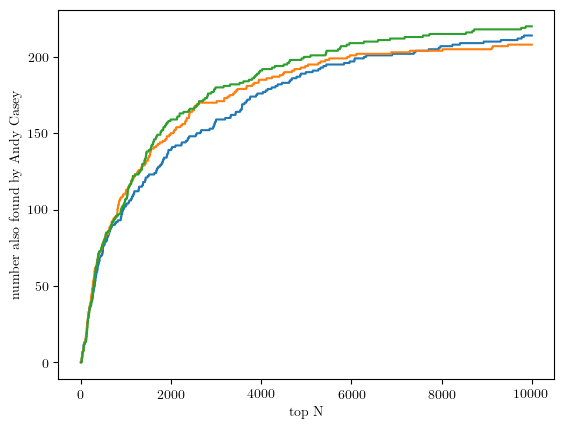

PyObject Text(22.299550986642984, 0.5, 'number also found by Andy Casey')

In [37]:
N = 10000
function f(df)
    map(1:N) do i
        length(intersect(Set(df.obsid[1:i]), battery))
    end
end
plot(1:N, f(sk4df))
plot(1:N, f(sk8df))
plot(1:N, f(sk16df))
xlabel("top N")
ylabel("number also found by Andy Casey")